In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [3]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [4]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

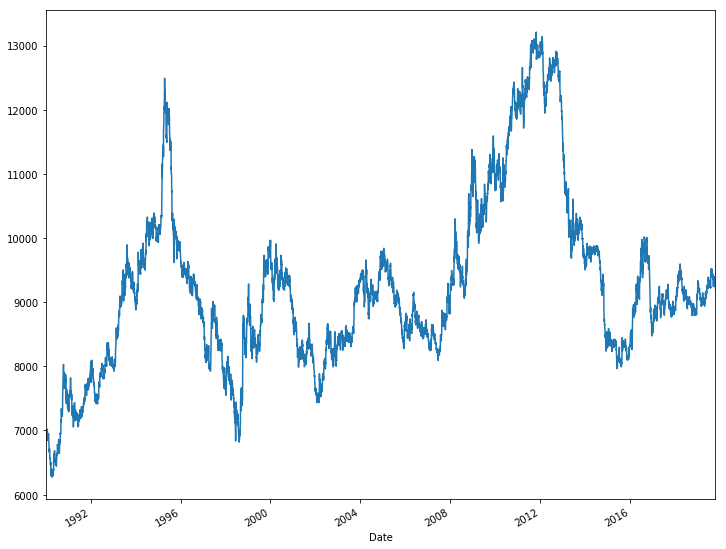

In [5]:
# Plot just the "Settle" column from the dataframe:
yen_futures.Settle.plot(figsize=(12,10))

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [6]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
yen_fut_noise, yen_fut_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])


In [7]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
yen_fut_df = pd.DataFrame(yen_futures['Settle'])
yen_fut_df['noise'] = yen_fut_noise
yen_fut_df['trend'] = yen_fut_trend
yen_fut_df.head()

,Settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


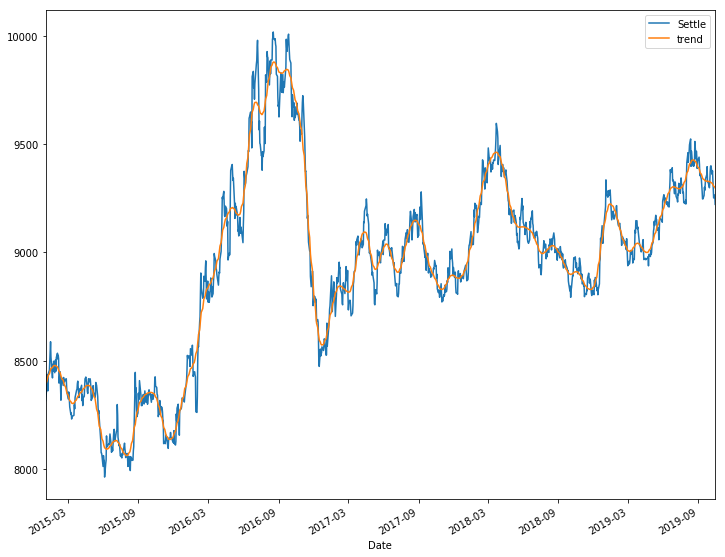

In [8]:
# Plot the Settle Price vs. the Trend for 2015 to the present
yen_fut_df['2015':][['Settle', 'trend']].plot(figsize=(12,10))

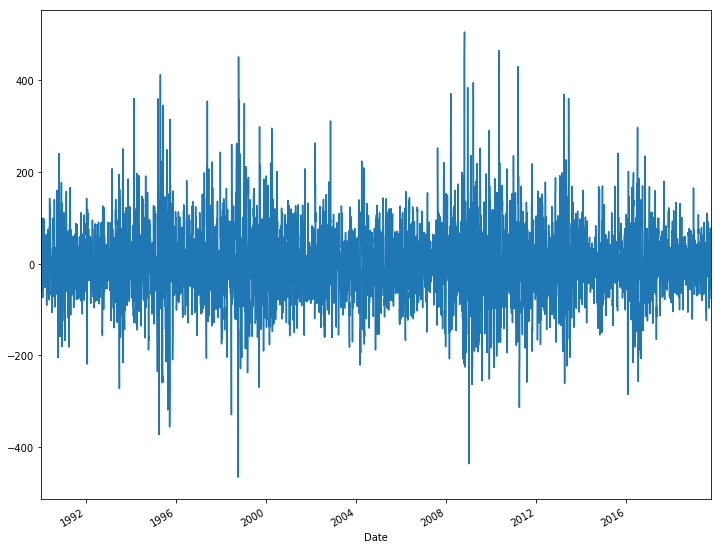

In [9]:
# Plot the Settle Noise
yen_fut_df['noise'].plot(figsize=(12,10))

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [10]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures.Settle.pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

Date
2019-10-09   -0.410601
2019-10-10   -0.369458
2019-10-11   -0.564304
2019-10-14    0.151335
2019-10-15   -0.469509
Name: Settle, dtype: float64

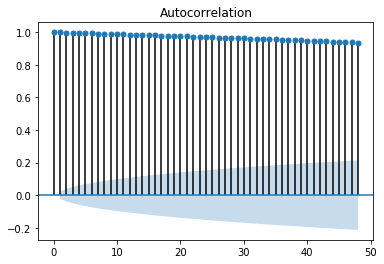

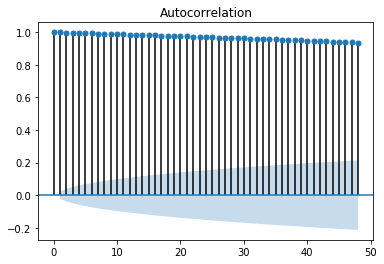

In [11]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(yen_futures.Settle, lags=48)

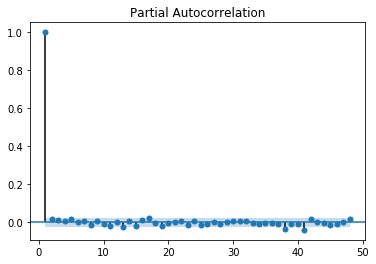

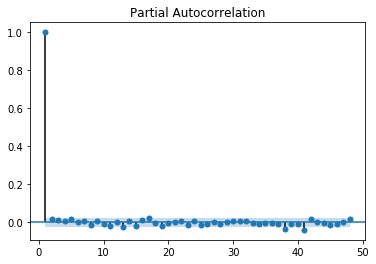

In [15]:
plot_pacf(yen_futures.Settle, lags=48, zero=False)

In [16]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',FutureWarning)
# warnings.filterwarnings('ignore', 'statsmodels.tsa.base.tsa_model',ValueWarning)
# warnings.filterwarnings('ignore', 'statsmodels.tsa.base.tsa_model',ValueWarning)

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(yen_futures.Settle, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

C:\Users\KetanHina\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [17]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7515
Model:                     ARMA(2, 1)   Log Likelihood              -41952.867
Method:                       css-mle   S.D. of innovations             64.277
Date:                Thu, 04 Mar 2021   AIC                          83915.733
Time:                        22:40:38   BIC                          83950.356
Sample:                             0   HQIC                         83927.621
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         9246.8139    676.633     13.666      0.000    7920.638    1.06e+04
ar.L1.Settle     1.6671      0.011    156.910      0.000       1.646       1.688
ar.L2.Settle    -0.6674      0.011    -62.882      0.000      -0.688      -0.647
ma.L1.Settle    -0.6832      0.013    -51.000      0.000      -0.709      -0.657
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0009           +0.0000j            1.0009            0.0000
AR.2            1.4969           +0.0000j            1.4969            0.0000
MA.1            1.4638           +0.0000j            1.4638            0.0000
-----------------------------------------------------------------------------
"""

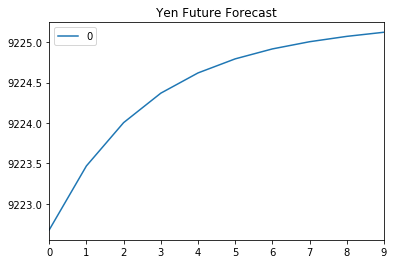

In [18]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=10)[0]).plot(title="Yen Future Forecast")

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [19]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
for p in range(1, 6): 
    d=1
    q=1
    
    arima_model = ARIMA(yen_futures.Settle, order=(p,1,1))

    # Fit the model
    arima_results = arima_model.fit()
    print(f'ARMA({p},{d},{q} - AIC:{arima_results.aic})')
    

C:\Users\KetanHina\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\KetanHina\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARMA(1,1,1 - AIC:83899.50362306775)


C:\Users\KetanHina\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\KetanHina\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARMA(2,1,1 - AIC:83903.178043147)


C:\Users\KetanHina\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\KetanHina\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARMA(3,1,1 - AIC:83902.01068449744)


C:\Users\KetanHina\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\KetanHina\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARMA(4,1,1 - AIC:83903.24234805744)


C:\Users\KetanHina\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\KetanHina\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARMA(5,1,1 - AIC:83905.23835636239)


In [30]:
# Output model summary results:
summary = arima_results.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Wed, 03 Mar 2021   AIC                          83905.238
Time:                        18:48:36   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3161      0.700      0.452      0.652      -1.056       1.688
ar.L1.D.Settle     0.2823      0.699      0.404      0.686      -1.088       1.653
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2973      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8919           -1.3785j            2.3409           -0.1002
AR.2            1.8919           +1.3785j            2.3409            0.1002
AR.3           -2.2710           -3.0198j            3.7785           -0.3526
AR.4           -2.2710           +3.0198j            3.7785            0.3526
AR.5          -11.1022           -0.0000j           11.1022           -0.5000
MA.1            3.3631           +0.0000j            3.3631            0.0000
-----------------------------------------------------------------------------
"""

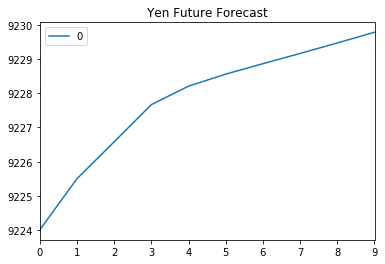

In [35]:
# Plot the 5 Day Price Forecast
pd.DataFrame(arima_results.forecast(steps=10)[0]).plot(title="Yen Future Forecast")

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [21]:
from arch import arch_model

In [26]:
# Estimate a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=2)

# Fit the model
results = model.fit(disp="off")

In [28]:
# Summarize the model results
display(results.summary)

<bound method ARCHModelResult.summary of                        Zero Mean - GARCH Model Results                        
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7452.15
Distribution:                  Normal   AIC:                           14914.3
Method:            Maximum Likelihood   BIC:                           14948.9
                                        No. Observations:                 7514
Date:                Thu, Mar 04 2021   Df Residuals:                     7509
Time:                        22:43:21   Df Model:                            5
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      6.9

In [29]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [31]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = results.forecast(start=last_day, horizon=forecast_horizon)

In [32]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.537532,7.474827,7.575985,7.583331,7.642838


In [33]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.537532
h.2,7.474827
h.3,7.575985
h.4,7.583331
h.5,7.642838


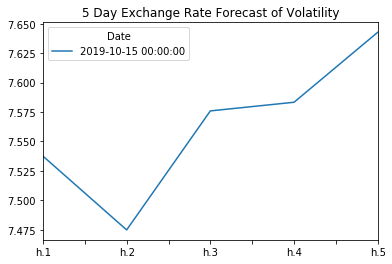

In [34]:
# Plot the final forecast
final.plot(title="5 Day Exchange Rate Forecast of Volatility")

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

1. 
Based on the 5 days forecast the Yen futures seems to go higher from current level. 
Hence it make sesne to go long on yen futures with stop loss ofcourse (not mentioned stop loss levels here) 

2. 
As per garch model forecast the Volatility expected to go up slighly (from 7.475 to 7.65). hence the risk of yen is expected to increase. 

3.
Yes, based on Arima and Garch model implementation, and p values and AIC numbers for ARMA(2.1) model the forecast seems quite reasonable for short term. It can be used for trading. 
